# Shift-VAE: Application to 1D spectra with arbitrary offset in peak position

Prepared by Maxim Ziatdinov


---

This notebook denonstrates how to use shift-VAE to disentangle the representations of a 1D spectral data set, ignoring relative positions of the peaks.

---



E-mail: ziatdinovmax@gmail.com

Install pyroVED package:

In [1]:
# Install the latest version from source
# (or you may instal a stable version from PyPi instead with !pip install pyroved)
!pip install -q git+https://github.com/ziatdinovmax/pyroved.git

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 9.3 MB/s eta 0:00:00


In [2]:
import os
import math
import numpy as np
import seaborn as sns
import pandas as pd
import time
import random

import torch

from torch.nn import Conv1d, ConvTranspose1d
from torch.nn import Linear as Lin, ReLU, Sigmoid, ConstantPad1d
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold

from matplotlib import pyplot as plt
from tqdm import tqdm

In [3]:
import pyroved as pv
import torch
import matplotlib.pyplot as plt

First, we prepare our synthetic data representing 1D Gaussian signals with different widths that is randomly shifted along the *x*-axis and is corrupted by noise. In other words, in this example we assume that the only physical factor of variation is a signal width and other forms of variations are considered to be "instrumental distortion".

In [4]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:

X_train = np.load("/content/drive/MyDrive/Aerosols_Proj/Lab_X_train.npy")
Y_train = np.load("/content/drive/MyDrive/Aerosols_Proj/Lab_Y_train.npy")

X_val = np.load("/content/drive/MyDrive/Aerosols_Proj/Lab_X_val.npy")
Y_val = np.load("/content/drive/MyDrive/Aerosols_Proj/Lab_Y_val.npy")

X_test = np.load("/content/drive/MyDrive/Aerosols_Proj/Lab_X_test.npy")
Y_test = np.load("/content/drive/MyDrive/Aerosols_Proj/Lab_Y_test.npy")

In [6]:
X_train.shape

(140082, 400, 4)

In [7]:
Y_train.shape

(140082,)

[ 0.20994424 -0.01571807 -0.0024818  -2.26821561]
[0.31285626 0.02564527 0.06866314 0.04089219]
[ 0.24451673  0.0297816  -0.02316347 -0.34197646]
[0.31722429 0.01654533 0.0471542  0.48921933]
[ 0.79129492 -0.00330907 -0.0521178  -1.08636927]


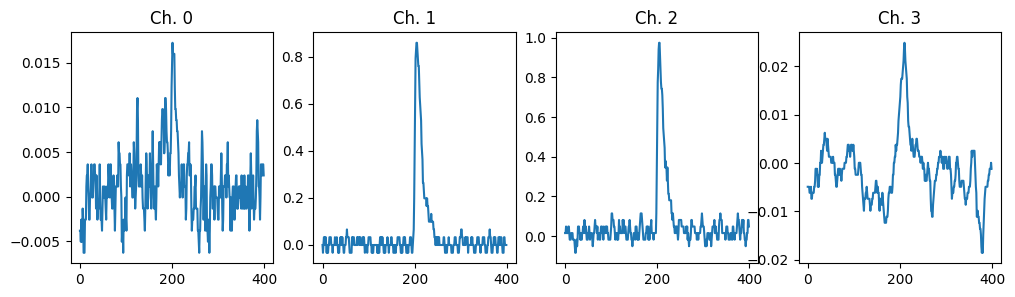

In [8]:
n = random.randint(1, 140081)
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,3))
axes[0].plot(X_train[n,:,0])
axes[0].set_title("Ch. 0")
axes[1].plot(X_train[n,:,1])
axes[1].set_title("Ch. 1")
axes[2].plot(X_train[n,:,2])
axes[2].set_title("Ch. 2")
axes[3].plot(X_train[n,:,3])
axes[3].set_title("Ch. 3")

random_indices = [random.randint(0, 140081) for _ in range(5)]

for idx in random_indices:
    print(X_train[idx, 199, :])

#print out the channel 0, 1, 2, 3, 4 for one random aerosol sample in X_train.
#this will be acorss a 400 point time series


In [128]:
def gaussian(x, mu, sig):
    return torch.exp(-torch.pow(x - mu, 2.) / (2 * torch.pow(sig, 2.)))

n_samples = 5000 # number of samples
l_signal = 100 # signal length

# Generate synthetic dataset with randomly shifted noisy 1D signal
torch.manual_seed(1)  # for reproducibility
x = torch.linspace(-12, 12, l_signal).expand(n_samples, l_signal)
noise = torch.randint(1, 100, (n_samples, 1)) / 1e3
mu = torch.randint(-30, 30, size=(n_samples, 1)) / 10
sig = torch.randint(50, 500, size=(n_samples, 1)) / 1e2
train_data = gaussian(x, mu, sig) + noise * torch.randn(size=(n_samples, l_signal))
# Normalize to (0, 1)
train_data = (train_data - train_data.min()) / (train_data.max() - train_data.min())

# Initialize train loader
train_loader = pv.utils.init_dataloader(train_data.unsqueeze(1), batch_size=64)

In [ ]:
fig, axes = plt.subplots(8, 8, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax, (y,) in zip(axes.flat, train_loader):
    ax.plot(x[0], y[0, 0])

In [9]:
original_max_X_train = np.zeros((140082, 4))
for p_idx in range(140082):
  for c_idx in range(4):
    original_max_X_train[p_idx][c_idx] = np.max(X_train[p_idx, :, c_idx])


In [10]:
X_train.shape

(140082, 400, 4)

In [11]:
peak_height = np.max(X_train[:, :, 1])
print(peak_height)

132.61664460622106


In [12]:
#SATURATION NUMERIC


#creating a more accurate delta eps values.



# Specify  epsilon value, like how tolerant will be to change
eps = 0.001

# Step 1: Find the maximum signal per particle in Channel 0
max_signal_channel_0 = np.max(X_train[:, :, 0], axis=1)

# Step 2: Count the number of points within epsilon of the maximum for each particle in Channel 0
# This comparison now includes the epsilon tolerance around the maximum signal
count_max_signal_channel_0 = np.sum((X_train[:, :, 0] >= (max_signal_channel_0[:, np.newaxis] - eps)) &
                                    (X_train[:, :, 0] <= (max_signal_channel_0[:, np.newaxis] + eps)), axis=1)

print(count_max_signal_channel_0/400*100)
count_max_signal_channel_0.shape





[ 0.25  0.5   0.25 ... 14.25  8.75 28.75]


(140082,)

In [13]:
max1 = np.max(X_train[:, :, 1], axis=1)  # Maximum value along axis 1 (400 points)
max2 = np.max(X_train[:, :, 2], axis=1)  # Maximum value along axis 1 (400 points)

# Calculate the color channel ratio for all 400 points
color_channel_ratio = max2 / max1

color_channel_ratio

array([1.11002002, 1.08262394, 1.21032505, ..., 1.52508171, 1.49707908,
       1.61149563])

In [14]:
channel_min_X_train = np.zeros((140082, 4))
channel_max_X_train = np.zeros((140082, 4))

# WOULD APPLY SAME LOGIC TO VALIDATION AND TEST DATASETS

for p_idx in range(140082):
  for c_idx in range(4):
    channel_min_X_train[p_idx][c_idx] = np.min(X_train[p_idx, :, c_idx])

  for c_idx in range(4):
    channel_max_X_train[p_idx][c_idx] = np.max(X_train[p_idx, :, c_idx])


for p_idx in range (0,140082):
  for c_idx in range(0, 4):
    s0 = (X_train[p_idx,:,c_idx] - channel_min_X_train[p_idx][c_idx])/(channel_max_X_train[p_idx][c_idx]- channel_min_X_train[p_idx][c_idx])
    X_train[p_idx,:,c_idx] = s0

X_train

array([[[4.01606426e-03, 2.49376559e-03, 6.71140940e-03, 2.07009858e-01],
        [4.01606426e-03, 0.00000000e+00, 4.47427293e-03, 2.07009858e-01],
        [2.67737617e-03, 0.00000000e+00, 4.47427293e-03, 2.07009858e-01],
        ...,
        [5.35475234e-03, 2.49376559e-03, 6.71140940e-03, 2.07009858e-01],
        [1.07095047e-02, 2.49376559e-03, 1.11856823e-02, 2.07009858e-01],
        [8.03212851e-03, 2.49376559e-03, 8.94854586e-03, 2.07009858e-01]],

       [[1.90476190e-01, 5.76923077e-02, 7.01754386e-02, 3.93442623e-01],
        [1.90476190e-01, 5.76923077e-02, 7.01754386e-02, 3.77049180e-01],
        [2.38095238e-01, 3.84615385e-02, 5.26315789e-02, 3.93442623e-01],
        ...,
        [1.42857143e-01, 3.84615385e-02, 5.26315789e-02, 2.95081967e-01],
        [9.52380952e-02, 3.84615385e-02, 3.50877193e-02, 2.62295082e-01],
        [7.14285714e-02, 3.84615385e-02, 3.50877193e-02, 2.62295082e-01]],

       [[4.16666667e-01, 1.33333333e-01, 1.05263158e-01, 5.55555556e-01],
        

In [15]:
print(type(X_train))

<class 'numpy.ndarray'>


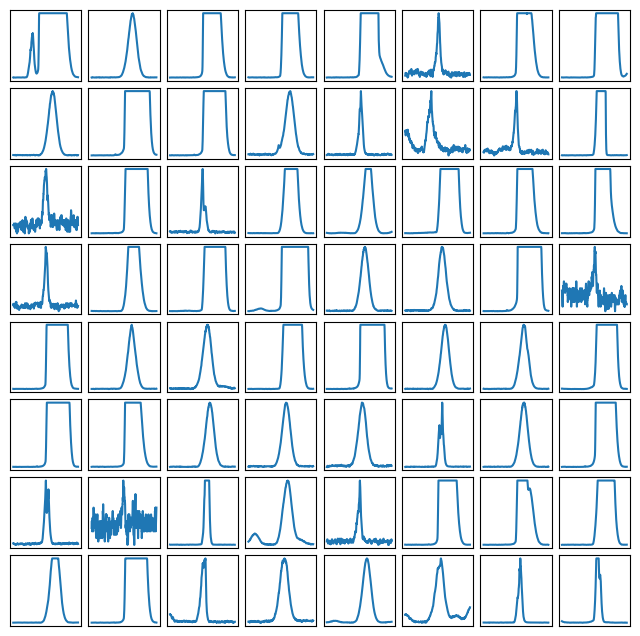

In [16]:
#FOR CHANNEL 0

X_train_C0 = torch.from_numpy(X_train[:,:, 0]).float()

#.unsqueeze(1) adds another channel
train_loader_0 = pv.utils.init_dataloader(X_train_C0.unsqueeze(1), batch_size=64)

fig, axes = plt.subplots(8, 8, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax, (y,) in zip(axes.flat, train_loader_0):
    y_use = y.numpy()
    ax.plot(y_use[0, 0])




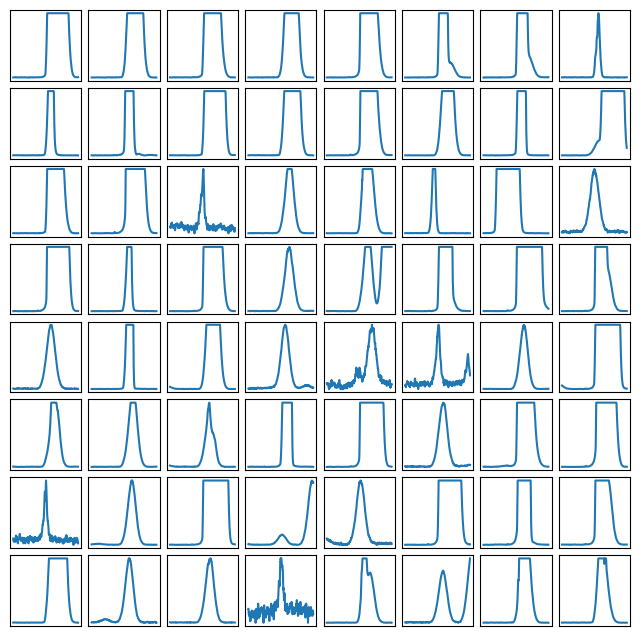

In [17]:
#FOR CHANNEL 1

X_train_C1 = torch.from_numpy(X_train[:,:, 1]).float()

#.unsqueeze(1) adds another channel
train_loader_1 = pv.utils.init_dataloader(X_train_C0.unsqueeze(1), batch_size=64)

fig, axes = plt.subplots(8, 8, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax, (y,) in zip(axes.flat, train_loader_1):
    y_use = y.numpy()
    ax.plot(y_use[0, 0])


Our goal is to find the real/physical descriptor of the data set in an unsupervised fashion, while ignoring (or separating) relative positions of the peaks. First, let's train a regular VAE:

In [18]:
channel_0 = (140081, )

# Initialize vanilla VAE
# Insert the color channel ratio here?

vae = pv.models.iVAE(data_dim = (400,), latent_dim = 2, invariances=None, seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae)

# Train for n epochs:
for e in range(28):
    trainer.step(train_loader_0)
    trainer.print_statistics()

Epoch: 1 Training loss: 84.7460
Epoch: 2 Training loss: 79.6206
Epoch: 3 Training loss: 78.9886
Epoch: 4 Training loss: 78.6018
Epoch: 5 Training loss: 78.3127
Epoch: 6 Training loss: 78.1704
Epoch: 7 Training loss: 78.0525
Epoch: 8 Training loss: 77.9271
Epoch: 9 Training loss: 77.8932
Epoch: 10 Training loss: 77.7721
Epoch: 11 Training loss: 77.7879
Epoch: 12 Training loss: 77.6806
Epoch: 13 Training loss: 77.6442
Epoch: 14 Training loss: 77.6252
Epoch: 15 Training loss: 77.5802
Epoch: 16 Training loss: 77.5655
Epoch: 17 Training loss: 77.5099
Epoch: 18 Training loss: 77.4890
Epoch: 19 Training loss: 77.4737
Epoch: 20 Training loss: 77.4233
Epoch: 21 Training loss: 77.4357
Epoch: 22 Training loss: 77.3958
Epoch: 23 Training loss: 77.4277
Epoch: 24 Training loss: 77.4968
Epoch: 25 Training loss: 77.3999
Epoch: 26 Training loss: 77.3724
Epoch: 27 Training loss: 77.3477
Epoch: 28 Training loss: 77.3313


In [19]:
channel_1 = (140081, )

# Initialize vanilla VAE
# Insert the color channel ratio here?

vae = pv.models.iVAE(data_dim = (400,), latent_dim = 2, invariances=None, seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae)

# Train for n epochs:
for e in range(28):
    trainer.step(train_loader_1)
    trainer.print_statistics()

Epoch: 1 Training loss: 84.7460
Epoch: 2 Training loss: 79.6206
Epoch: 3 Training loss: 78.9886
Epoch: 4 Training loss: 78.6018
Epoch: 5 Training loss: 78.3127
Epoch: 6 Training loss: 78.1704
Epoch: 7 Training loss: 78.0525
Epoch: 8 Training loss: 77.9271
Epoch: 9 Training loss: 77.8932
Epoch: 10 Training loss: 77.7721
Epoch: 11 Training loss: 77.7879
Epoch: 12 Training loss: 77.6806
Epoch: 13 Training loss: 77.6442
Epoch: 14 Training loss: 77.6252
Epoch: 15 Training loss: 77.5802
Epoch: 16 Training loss: 77.5655
Epoch: 17 Training loss: 77.5099
Epoch: 18 Training loss: 77.4890
Epoch: 19 Training loss: 77.4737
Epoch: 20 Training loss: 77.4233
Epoch: 21 Training loss: 77.4357
Epoch: 22 Training loss: 77.3958
Epoch: 23 Training loss: 77.4277
Epoch: 24 Training loss: 77.4968
Epoch: 25 Training loss: 77.3999
Epoch: 26 Training loss: 77.3724
Epoch: 27 Training loss: 77.3477
Epoch: 28 Training loss: 77.3313


Encode the training data into the latent space:

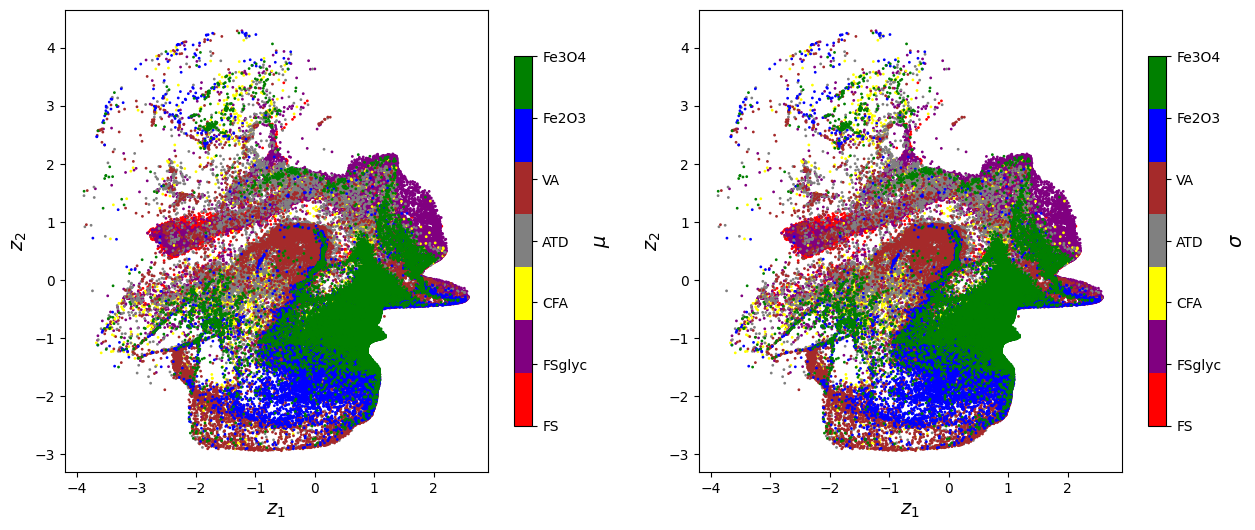

In [20]:
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib.colors import ListedColormap

# z_mean, z_sd = vae.encode(X_train_C0)
# fig = plt.figure(figsize=(15, 6))
# ax1 = fig.add_subplot(121, projection = '3d')
# ax2 = fig.add_subplot(122, projection = '3d')
# target_names = ["FS", "FSglyc", "CFA", "ATD", "VA", "Fe2O3", "Fe3O4"]

# cmap1 = ListedColormap(['red', 'purple', 'yellow', 'gray', 'brown', 'blue', 'green'])
# im1 = ax1.scatter(z_mean[:, -1], z_mean[:, -2], z_mean[:, -3], s=1, c=Y_train, cmap=cmap1)
# ax1.set_xlabel("$z_1$", fontsize=14)
# ax1.set_ylabel("$z_2$", fontsize=14)
# ax1.set_zlabel("$z_3$", fontsize=14)
# cbar1 = fig.colorbar(im1, ax=ax1, ticks=range(len(cmap1.colors)), shrink=.8)
# cbar1.set_ticklabels(target_names)
# cbar1.set_label("$\mu$", fontsize=14)

# cmap2 = ListedColormap(['red', 'purple', 'yellow', 'gray', 'brown', 'blue', 'green'])
# im2 = ax2.scatter(z_mean[:, -1], z_mean[:, -2], s=1, c=Y_train, cmap=cmap2)
# ax2.set_xlabel("$z_1$", fontsize=14)
# ax2.set_ylabel("$z_2$", fontsize=14)
# ax2.set_zlabel("$z_3$", fontsize=14)
# cbar2 = fig.colorbar(im2, ax=ax2, ticks=range(len(cmap2.colors)), shrink=.8)
# cbar2.set_ticklabels(target_names)
# cbar2.set_label("$\sigma$", fontsize=14)

# plt.show()


import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

z_mean, z_sd = vae.encode(X_train_C0)
fig = plt.figure(figsize=(15, 6))

# First subplot
ax1 = fig.add_subplot(121)  # No longer 3D
target_names = ["FS", "FSglyc", "CFA", "ATD", "VA", "Fe2O3", "Fe3O4"]
cmap1 = ListedColormap(['red', 'purple', 'yellow', 'gray', 'brown', 'blue', 'green'])
im1 = ax1.scatter(z_mean[:, -1], z_mean[:, -2], s=1, c=Y_train, cmap=cmap1)
ax1.set_xlabel("$z_1$", fontsize=14)
ax1.set_ylabel("$z_2$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, ticks=range(len(cmap1.colors)), shrink=.8)
cbar1.set_ticklabels(target_names)
cbar1.set_label("$\mu$", fontsize=14)

# Second subplot
ax2 = fig.add_subplot(122)  # No longer 3D
cmap2 = ListedColormap(['red', 'purple', 'yellow', 'gray', 'brown', 'blue', 'green'])
im2 = ax2.scatter(z_mean[:, -1], z_mean[:, -2], s=1, c=Y_train, cmap=cmap2)
ax2.set_xlabel("$z_1$", fontsize=14)
ax2.set_ylabel("$z_2$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, ticks=range(len(cmap2.colors)), shrink=.8)
cbar2.set_ticklabels(target_names)
cbar2.set_label("$\sigma$", fontsize=14)

plt.show()


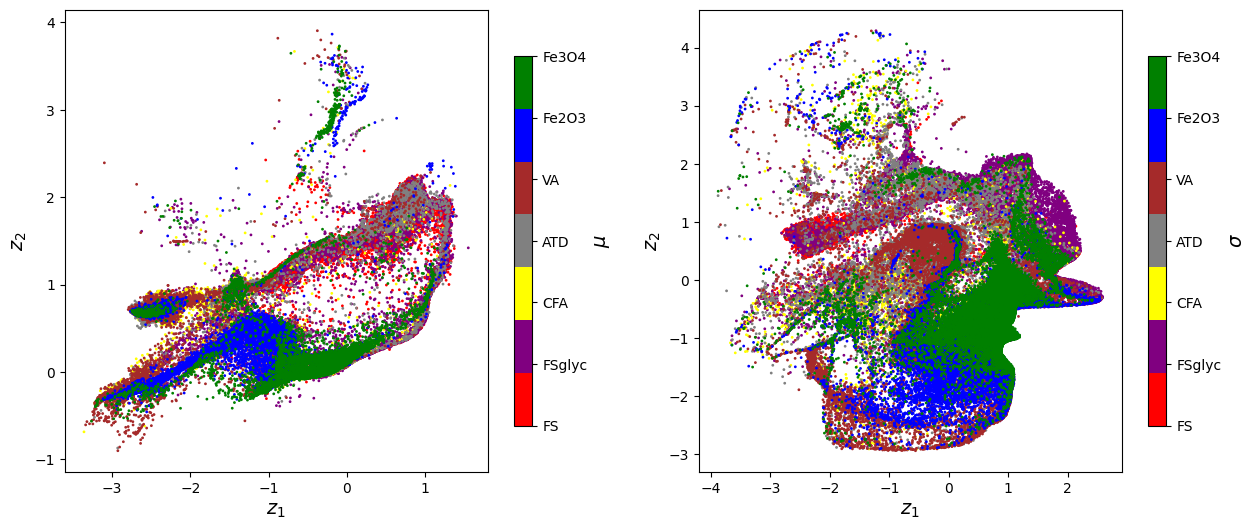

In [21]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

z_mean_1, z_sd_1 = vae.encode(X_train_C1)
fig = plt.figure(figsize=(15, 6))

# First subplot for z_mean_1
ax1 = fig.add_subplot(121)  # No longer 3D
target_names = ["FS", "FSglyc", "CFA", "ATD", "VA", "Fe2O3", "Fe3O4"]
cmap1 = ListedColormap(['red', 'purple', 'yellow', 'gray', 'brown', 'blue', 'green'])
im1 = ax1.scatter(z_mean_1[:, -1], z_mean_1[:, -2], s=1, c=Y_train, cmap=cmap1)
ax1.set_xlabel("$z_1$", fontsize=14)
ax1.set_ylabel("$z_2$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, ticks=range(len(cmap1.colors)), shrink=.8)
cbar1.set_ticklabels(target_names)
cbar1.set_label("$\mu$", fontsize=14)

# Second subplot for z_mean
ax2 = fig.add_subplot(122)  # No longer 3D
cmap2 = ListedColormap(['red', 'purple', 'yellow', 'gray', 'brown', 'blue', 'green'])
im2 = ax2.scatter(z_mean[:, -1], z_mean[:, -2], s=1, c=Y_train, cmap=cmap2)
ax2.set_xlabel("$z_1$", fontsize=14)
ax2.set_ylabel("$z_2$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, ticks=range(len(cmap2.colors)), shrink=.8)
cbar2.set_ticklabels(target_names)
cbar2.set_label("$\sigma$", fontsize=14)

plt.show()

In [22]:
X_train_C0.shape

torch.Size([140082, 400])

In [23]:
X_train.shape

(140082, 400, 4)

In [24]:
original_max_X_train.shape

(140082, 4)

In [25]:
incandescent_max = []
incandescent_max = original_max_X_train[:, 1]

new_incandescent_max = np.expand_dims(incandescent_max, axis = 1)
new_incandescent_max.shape

(140082, 1)

In [26]:
X_train.shape

(140082, 400, 4)

In [27]:
scattering = []
scattering = original_max_X_train[:, 0]

new_scattering = np.expand_dims(scattering, axis = 1)
new_scattering.shape

(140082, 1)

In [28]:
z_mean.shape

torch.Size([140082, 2])

In [29]:
color_channel_ratio.shape
color_channel_ratio = np.array(color_channel_ratio)
color_channel_ratio = np.expand_dims(color_channel_ratio, axis = 1)

color_channel_ratio.shape

(140082, 1)

In [30]:
np.count_nonzero(np.isinf(color_channel_ratio))
bad_data = np.isinf(color_channel_ratio)
bad_data = bad_data[:, 0]
bad_data.shape

(140082,)

In [31]:
from sklearn.preprocessing import MinMaxScaler
X_all = np.concatenate((z_mean.numpy(), z_mean_1.numpy(), new_scattering, new_incandescent_max, color_channel_ratio), axis = 1)
X_filtered = X_all[~bad_data,:]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_filtered)
X_scaled.shape

(140082, 7)

In [32]:
Y_filtered = Y_train[~bad_data]
Y_filtered
Y_filtered.shape

(140082,)

In [33]:
z_mean.shape

torch.Size([140082, 2])

In [34]:
z_mean_1.shape

torch.Size([140082, 2])

In [35]:
new_scattering.shape

(140082, 1)

In [36]:
new_scattering

array([[0.9186803 ],
       [0.04637546],
       [0.00833333],
       ...,
       [2.61570632],
       [2.61654275],
       [2.61728625]])

In [37]:
new_incandescent_max

array([[13.22634017],
       [ 1.65205162],
       [ 0.43266049],
       ...,
       [23.28590338],
       [ 9.48792191],
       [23.54649239]])

In [38]:
color_channel_ratio

array([[1.11002002],
       [1.08262394],
       [1.21032505],
       ...,
       [1.52508171],
       [1.49707908],
       [1.61149563]])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


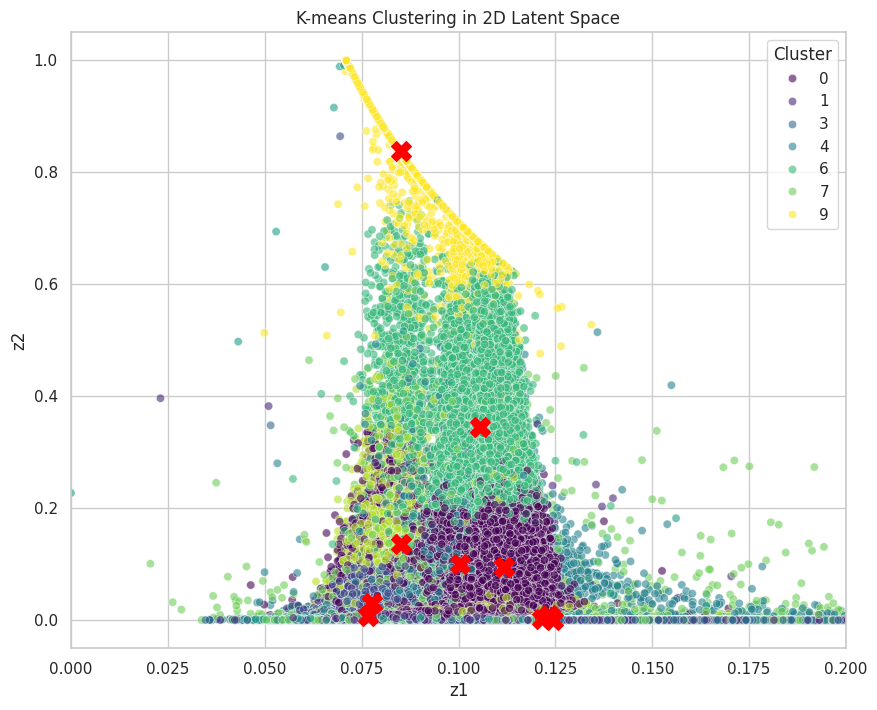

In [50]:
from sklearn.cluster import KMeans

n_clusters = 10

kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X_scaled) #fit alll of the parameters here

kmeans_labels = kmeans.labels_

kmeans_centers = kmeans.cluster_centers_

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data = pd.DataFrame(X_scaled, columns=['z1', 'z2', 'z3', 'z4', 'scattering_max', 'incandescent_max', 'color_ratio'])
data['Cluster'] = kmeans_labels

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 8))
sns.scatterplot(data=data, x='color_ratio', y='incandescent_max', hue='Cluster', palette='viridis', alpha=0.6)

for center in kmeans_centers:
    plt.scatter(center[6], center[5], s=200, c='red', marker='X')

plt.title('K-means Clustering in 2D Latent Space')
plt.xlabel('z1')
plt.ylabel('z2')

plt.xlim(0, 0.2)
#plt.zlabel('z3')
plt.legend(title='Cluster')

plt.show()

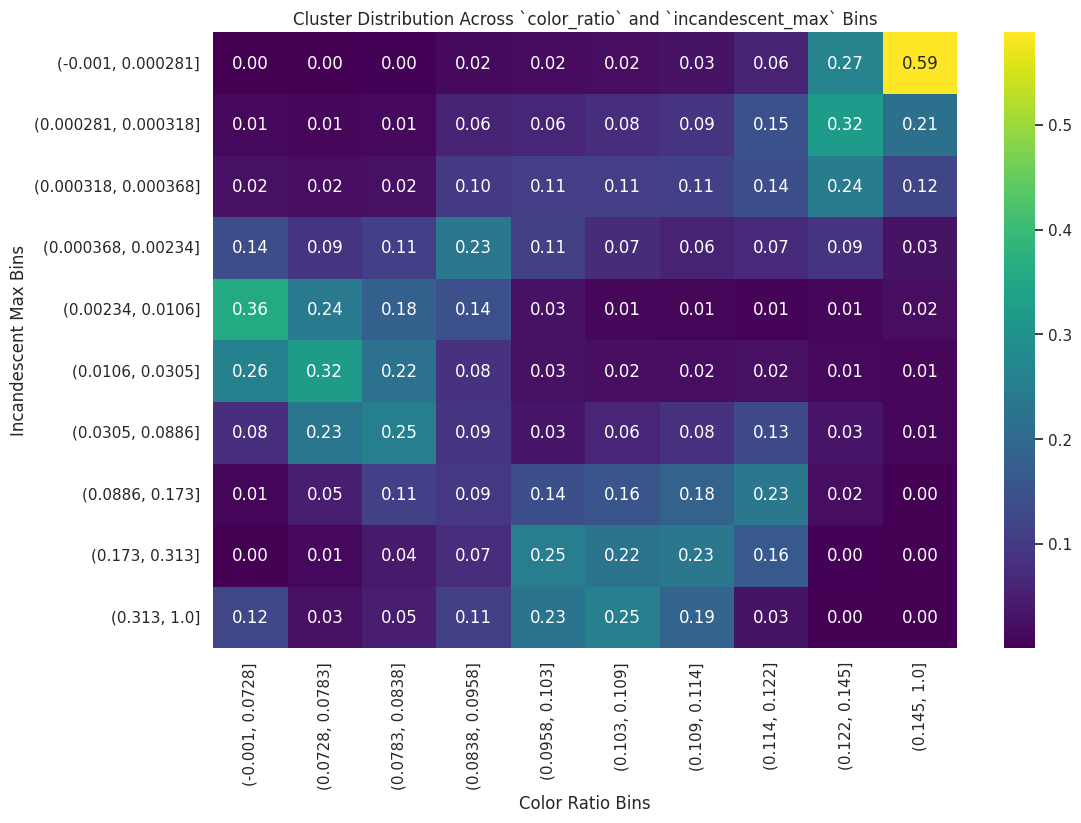

In [ ]:
data['color_ratio_bins'] = pd.qcut(data['color_ratio'], q=10, duplicates='drop')  # 10 quantile-based bins
data['incandescent_max_bins'] = pd.qcut(data['incandescent_max'], q=10, duplicates='drop')

# Creating a cross-tabulation of bins and cluster labels to count occurrences
ct = pd.crosstab(index=data['incandescent_max_bins'], columns=data['color_ratio_bins'], values=data['Cluster'], aggfunc='count', normalize='index')

# Heatmap of the cross-tabulation (probability distribution of clusters across bins)
plt.figure(figsize=(12, 8))
sns.heatmap(ct, annot=True, fmt=".2f", cmap='viridis')
plt.title('Cluster Distribution Across `color_ratio` and `incandescent_max` Bins')
plt.xlabel('Color Ratio Bins')
plt.ylabel('Incandescent Max Bins')
plt.show()

IndexError: index 8 is out of bounds for axis 0 with size 5

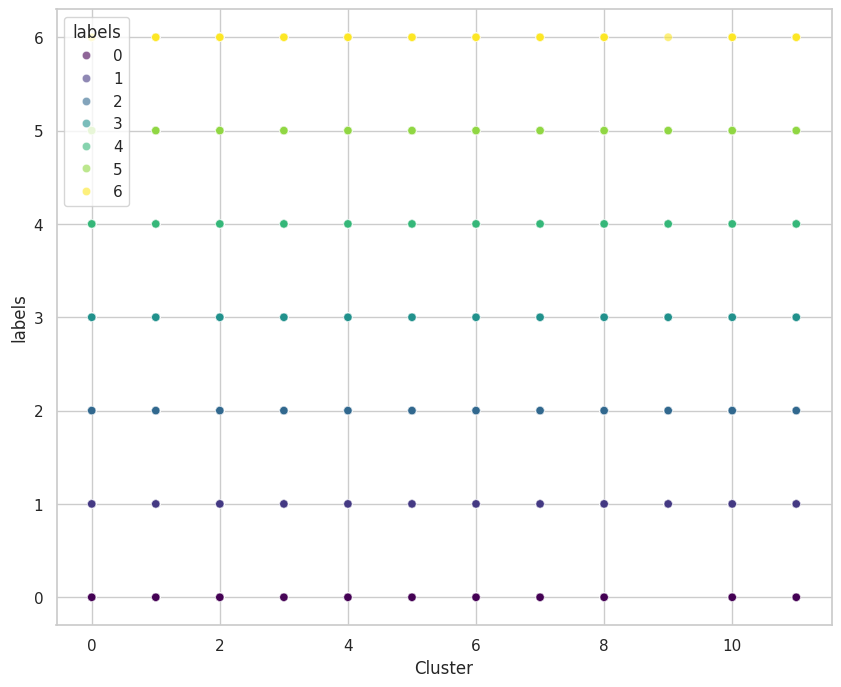

In [ ]:
from sklearn.cluster import KMeans


data = pd.DataFrame(X_scaled, columns=['z1', 'z2', 'z3', 'z4', 'z5', 'z6', 'scattering_max', 'incandescent_max', 'color_ratio'])
data['Cluster'] = kmeans_labels
data['labels'] = Y_filtered

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 8))
sns.scatterplot(data=data, x='Cluster', y='labels', hue='labels', palette='viridis', alpha=0.6)

for center in kmeans_centers:
    plt.scatter(center[8], center[7], s=200, c='red', marker='X')

plt.title('K-means Clustering in 2D Latent Space')
plt.xlabel('z1')
plt.ylabel('z2')

plt.xlim(0, 0.2)
plt.legend(title='labels')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


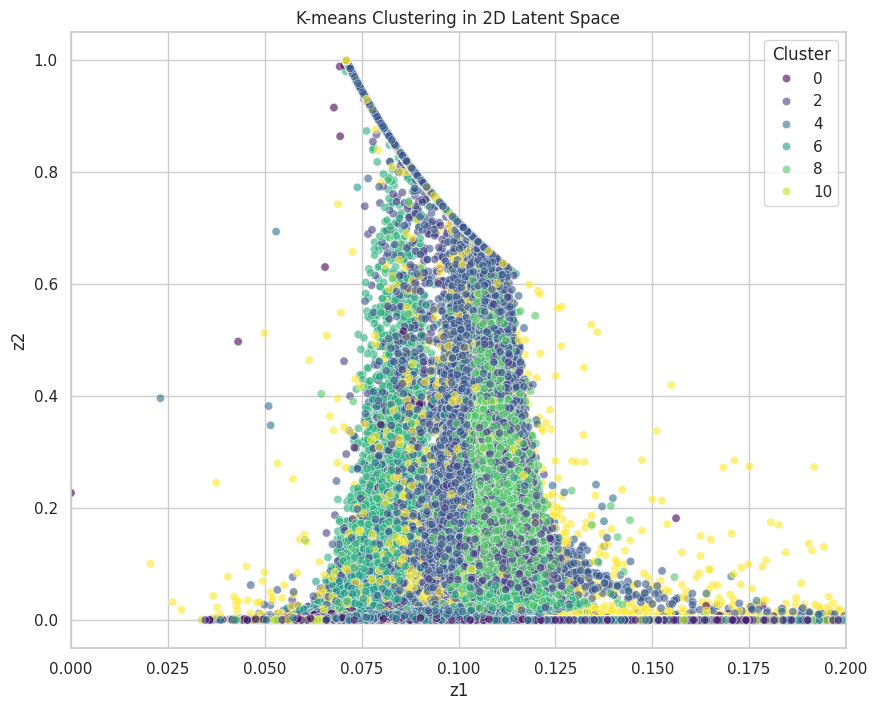

In [ ]:
from sklearn.cluster import KMeans

n_clusters = 12

kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X_scaled[:, 0:5]) #fit alll of the parameters here

kmeans_labels = kmeans.labels_

kmeans_centers = kmeans.cluster_centers_

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data = pd.DataFrame(X_scaled, columns=['z1', 'z2', 'z3', 'z4', 'z5', 'z6', 'scattering_max', 'incandescent_max', 'color_ratio'])
data['Cluster'] = kmeans_labels

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 8))
sns.scatterplot(data=data, x='color_ratio', y='incandescent_max', hue='Cluster', palette='viridis', alpha=0.6)

# for center in kmeans_centers:
#     plt.scatter(center[8], center[7], s=200, c='red', marker='X')

plt.title('K-means Clustering in 2D Latent Space')
plt.xlabel('z1')
plt.ylabel('z2')

plt.xlim(0, 0.2)
plt.legend(title='Cluster')

plt.show()

In [ ]:
print(kmeans_labels)
print(Y_filtered)

#count how manny 0s 1s,


[4 6 6 ... 3 4 3]
[0. 0. 0. ... 6. 6. 6.]


numpy.ndarray

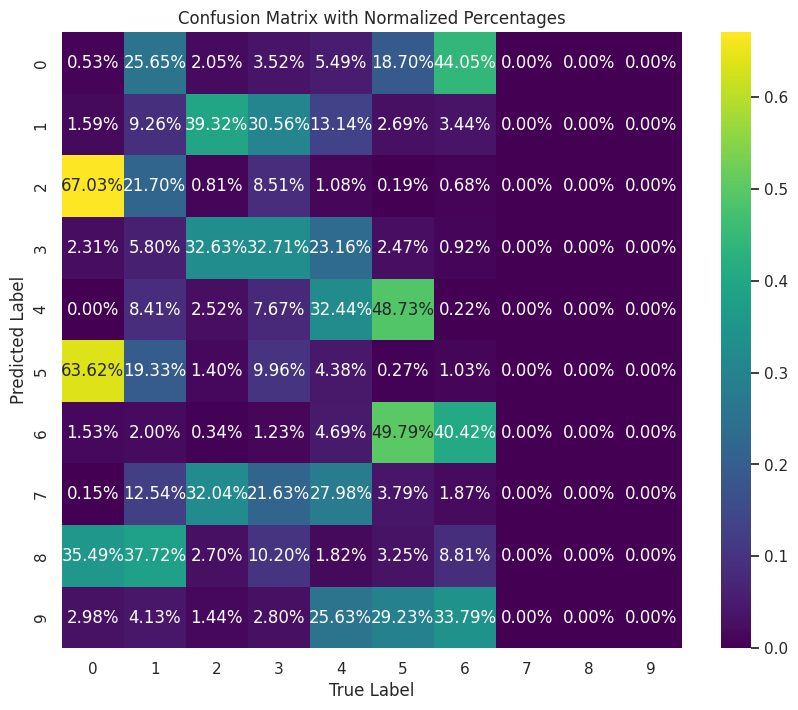

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming kmeans_labels are your cluster labels and Y_filtered are your actual labels
correlation_arr = confusion_matrix(kmeans_labels, Y_filtered, normalize='true')

# Create a heatmap with annotations that display percentages
plt.figure(figsize=(10, 8))  # Adjust the size of the plot as needed
ax = sns.heatmap(correlation_arr, annot=True, fmt=".2%", cmap='viridis')
ax.set_title('Confusion Matrix with Normalized Percentages')
ax.set_ylabel('Predicted Label')
ax.set_xlabel('True Label')

plt.show()

In [ ]:
#for np.concatenate, don't forget the double parentheses to treat as list
label_to_cluster = np.stack((kmeans_labels, Y_filtered), axis = 1)

<Axes: >

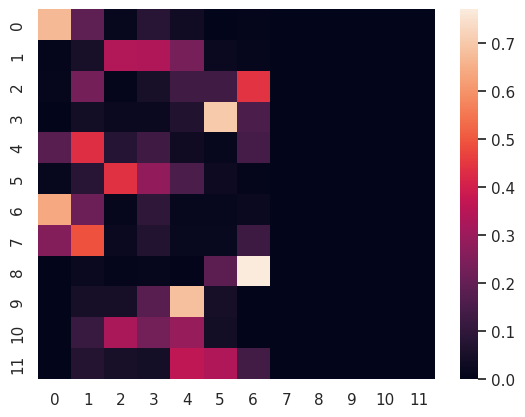

In [ ]:
from sklearn.metrics import confusion_matrix
correlation_arr = confusion_matrix(kmeans_labels, Y_filtered, normalize = 'true')
sns.heatmap(correlation_arr)

In [ ]:
kmeans_labels.shape

(140082,)

In [ ]:
Y_filtered.shape

(140082,)

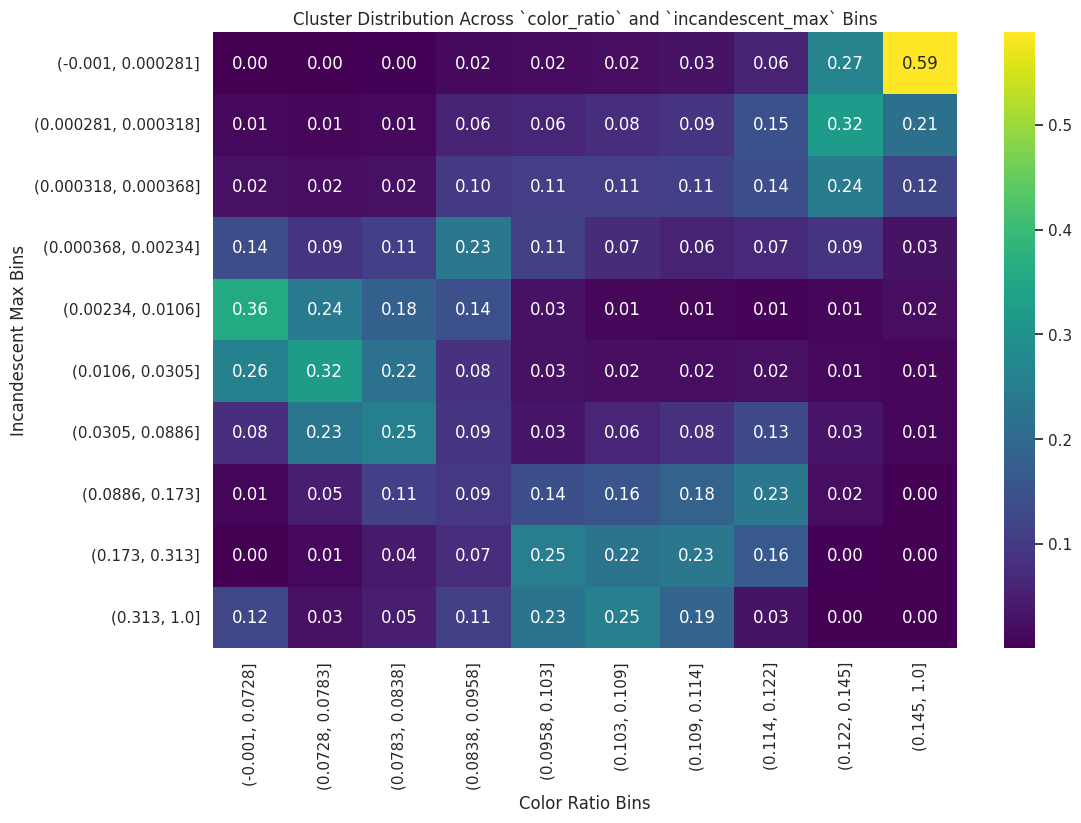

In [ ]:
#KMEANS PERCENTAGE
#CHANGING THE NUMBER OF CLUSTERS DIDNT SEEM TO HAVE IMPACT ON THE PROBABILITY DISTRIBUTIONS

data['color_ratio_bins'] = pd.qcut(data['color_ratio'], q=10, duplicates='drop')
data['incandescent_max_bins'] = pd.qcut(data['incandescent_max'], q=10, duplicates='drop')

# Creating a cross-tabulation of bins and cluster labels to count occurrences
ct = pd.crosstab(index=data['incandescent_max_bins'], columns=data['color_ratio_bins'], values=data['Cluster'], aggfunc='count', normalize='index')

# Heatmap of the cross-tabulation (probability distribution of clusters across bins)
plt.figure(figsize=(12, 8))
sns.heatmap(ct, annot=True, fmt=".2f", cmap='viridis')
plt.title('Cluster Distribution Across `color_ratio` and `incandescent_max` Bins')
plt.xlabel('Color Ratio Bins')
plt.ylabel('Incandescent Max Bins')
plt.show()



n_clusters = 7
#able to map labels to clusters


# when outputting the confusion matrix, want to use the actual K-means data
# then would create heat maps for 7 by 7 , 8 by 8, 9 by 9
  #can have 7 labels but then maybe have 12 clusters
  #doesn't necessarily need to be squared
  #would allow us to determine possible the optimal number of clusters
  # even if we have more than 7 clusters, would allow us to see





# for point, label, pred_cluster in zip(X_test, testrealy, test_cluster_labels):
#   confusion_matrix[int(label)][int(pred_cluster)]+=1

# new_confusion_matrix = np.zeros((7,7))
# for i, row in enumerate(confusion_matrix):
#   row_total = sum(row)
#   for j, elem in enumerate(row):
#     new_confusion_matrix[i][j] = elem/row_total

# sns.heatmap(new_confusion_matrix, annot=True)


# kmeans(trainlatent, testlatent, trainrealy, testrealy, 7)

We can see that while there is definitely a relationship between ground truth variables and the encoded latent variables, they are not equal (even after if we do a "rescaling").

In [ ]:
print(Y_filtered)

[0. 0. 0. ... 6. 6. 6.]


In [ ]:
#ACTUAL LABEL PERCENTAGE

unique, counts = np.unique(Y_filtered, return_counts = True)
percentage = (counts/len(Y_filtered))*100
percentage_dict = (counts/len(Y_filtered)) * 100
print(percentage_dict)

[14.28020731 14.29020145 14.28377665 14.2780657  14.28092117 14.28306278
 14.30376494]


In [ ]:
#try heat map
#increase the number of clusters
#add numbers like (x% ) when comparing with the labelled data
#optimum number of clusters to use for k_means


#a better understanding of the data itself
# better ways to understand the dtata and what signals tell use
#because the signals are so high dimensional

